<br>

# Radiative Convective Equilibrium, Where does it hold? 

First we recreate using the ERA5 reanalysis data.

Question: Why are large negative R1 values valid for RCE?

## Set up

### Load libraries


In [1]:
# General libs for file paths, data extraction, etc
from glob import glob
from pathlib import Path
from os.path import basename
import zipfile # To extract zipfiles
import urllib3 
urllib3.disable_warnings() # Disable warnings for data download via API

# CDS API
import cdsapi

# Libraries for working with multi-dimensional arrays
import numpy as np
import xarray as xr
import nctoolkit as nc
import pandas as pd
from dask import delayed
from scipy.interpolate import griddata


# Libraries for plotting and visualising data
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature

from matplotlib import cm
# If any of these are missing, just pip install them to your conda environment, or run a cell with something like this: 
# !pip install cdsapi
# !pip install urllib3 

nctoolkit is using Climate Data Operators version 2.4.0


### Constants and Functions

In [2]:
# Constants and General Functions
earth_area_total = 5.11e14
R = 6.378e6

def frac_land_area(df, x):
    return sum(df['x'].mean(dim='longitude').isel(date=0) * 2 * np.pi * R * np.cos(df.latitude*np.pi/180) * 0.25 * np.pi/180 * R)/earth_area_total

def plot_R1(df, binary = False):
    fig = plt.figure(figsize=(20,10))
    ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())

    if binary:
        im = plt.pcolormesh(df['longitude'], df['latitude'],
                       df['R1']<0.1, transform=ccrs.PlateCarree())
    # Plot the averaged 2D map with pcolormesh
    else:
        im = plt.pcolormesh(df['longitude'], df['latitude'],
                       df['R1'], transform=ccrs.PlateCarree())

    
    # Add coast- and gridlines
    ax.coastlines(color='black')
    gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

    # Add title and legend
    #ax.set_title(f'R1 = 1+(LH+SH)/Q average for 1980. Grid sizes are 0.25 deg lat and long', fontsize=24)

    cbar = plt.colorbar(im,fraction=0.046, pad=0.04)
    cbar.set_label('\n R1 (unitless)',fontsize=20)
    # plt.savefig('./Plots/R1_1980_world.png')
    
    
# Proportion of time the area in between two latitude bands is in RCE
def get_frac(df, minlat = -90, maxlat = 90):
    return (df.where((df.latitude <= maxlat) & (df.latitude >= minlat)).mean('longitude') 
            * np.cos(np.pi/180*df.latitude)).mean('latitude')

<hr>

### Get Data and Reformat

### Request data from the CDS with the CDS API

Edit the KEY variable to include your personal User ID and CDS API key (found by logging in to http://cds.climate.copernicus.eu and navigating to https://cds.climate.copernicus.eu/api-how-to).

In [ ]:
URL = 'https://cds.climate.copernicus.eu/api'
KEY = '24cacaba-7f25-4efe-9b98-40828f792491'

In [ ]:
DATADIR = '/n/holystore01/LABS/mccoll_lab/Lab/amatthews/Data/'
filename='ERA5_RCE'

In [ ]:
%%time
filename='ERA5_RCE'
dataset = "reanalysis-era5-single-levels-monthly-means"
c = cdsapi.Client(url=URL, key=KEY)

request = {
    'product_type': ['monthly_averaged_reanalysis'],
    'variable': [
        'surface_latent_heat_flux', 
        'surface_sensible_heat_flux', 
        'surface_net_solar_radiation', 
        'surface_net_thermal_radiation', 
        'top_net_solar_radiation',
        'top_net_thermal_radiation',
        'land_sea_mask',
        'total_precipitation'
    ],
    'year': ['1980',
             '1981', '1982', '1983', '1984', '1985',
             '1986', '1987', '1988', '1989', '1990', '1991', 
             '1992', '1993', '1994', '1995', '1996', '1997', 
             '1998', '1999', '2000', '2001', '2002', '2003', 
             '2004', '2005'],
    'month': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'],
    'time': ['00:00'],
    'data_format': 'netcdf',
    'download_format': 'zip'
}

c.retrieve(dataset, request, 
          f'{DATADIR}{filename}.zip')



print(f'{DATADIR}{filename}.zip')

with zipfile.ZipFile(f'{DATADIR}{filename}.zip', 'r') as zip_ref:
    zip_ref.extractall(f'{DATADIR}')
    
cmip6_nc = list()
for file in glob(f'{DATADIR}*.nc'):
    cmip6_nc.append(basename(file))

In [ ]:
datafile_name = 'data_0.nc'
df_precip = xr.open_dataset(f'{DATADIR}{datafile_name}')

In [ ]:
df_precip['valid_time'] = pd.to_datetime(df_precip.valid_time).strftime('%Y%m%d').astype(int)
df_precip = df_precip.rename({'valid_time':'date'})
df = xr.merge((df,df_precip))

In [ ]:
df = xr.merge(df, df_precip)

### Calculate R1
- Q = net radiation
- SS, SL = surface solar/shortwave, longwave/thermal
- AS, AL = top of atmosphere shortwave, longwave
- R1 = RCE Proxy (Dimensionless)
- SH, LH = surface, latent heat flux
$$Q = (SS + SL) - (AS + AL)$$
$$ R_1 = 1 + \frac{SH + LH}{Q}$$

In [ ]:
def add_R1_col(df):
    df['Q'] = (df['str'] + df['ssr'])-(df['ttr'] + df['tsr'])
    df['R1'] = 1+(df['slhf'] + df['sshf']) / df['Q'] 

In [ ]:

# Radiation = surface solar + surface long - (top atm. solar + top atm. long)
# add_R1_col(df)

# df['Q'] = (df['str'] + df['ssr'])-(df['ttr'] + df['tsr'])
# df['R1'] = 1+(df['slhf'] + df['sshf']) / df['Q'] 

### Add weights for latitude and month length

In [ ]:
df = df.assign_coords({'month':np.round(df.date%10000/100).astype(int)})
df = df.assign_coords({'year':np.round(df.date/10000).astype(int)})
df = df.assign_coords({'land':df.lsm > 0.5})

In [ ]:
# Latitude weights
weight_adjustment = np.cos(df.latitude * np.pi/180).mean()
weights = np.cos(np.deg2rad(df.latitude)) / weight_adjustment
df['slhf_w'] = df.slhf * weights
df['sshf_w'] = df.sshf * weights
df['Q_w'] = df.Q * weights

In [5]:
# Month weights divided by len year
time = df['date'].to_index()

days_per_month = time.to_series().apply(lambda x: pd.to_datetime(x, format = '%Y%m%d').days_in_month * 12 / (365 + pd.to_datetime(x, format = '%Y%m%d').is_leap_year))
day_weights = xr.DataArray(
    days_per_month.values,
    coords={"date": df["date"]},
    dims=["date"]
)

# df['slhf_mw'] = day_weights * df.slhf
# df['Q_mw'] = day_weights * df.Q
# df['sshf_mw'] = day_weights * df.sshf
# df['R1_mw'] = 1 + (df.slhf_mw + df.sshf_mw) / df.Q_mw

In [4]:
# Month weights not divided by year
time = df['date'].to_index()

days_per_month = time.to_series().apply(lambda x: pd.to_datetime(x, format = '%Y%m%d').days_in_month)
days_df = xr.DataArray(
    days_per_month.values,
    coords={"date": df["date"]},
    dims=["date"]
)
df['tp_month'] = df.tp*days_df

### Save Data in new files for easy access

In [ ]:
data_temp = '/n/holystore01/LABS/mccoll_lab/Lab/amatthews/Data_temp/'
df.to_netcdf('df_Jan_22_25.nc')

### Open Saved Data

In [3]:
data_fold = '/n/holystore01/LABS/mccoll_lab/Lab/amatthews/Data_temp/'
# df_yr_zone = xr.open_dataset(data_fold + 'df_yr_zone.nc')
# df_yr_zone_land = xr.open_dataset(data_fold + 'df_yr_zone_land.nc')
# df_yr_zone_oc = xr.open_dataset(data_fold + 'df_yr_zone_oc.nc')
# as of Jan 16 2025, df2.nc has precip data as well
df = xr.open_dataset('df_Jan_22_25.nc')

## Analysis and Plot

### Zonally Averaged

In [ ]:
df_zone = df.R1_mw.mean('longitude').mean('date')

R1 = 1 + (df.sshf_mw.mean('date') + df.slhf_mw.mean('date')) / df.Q_mw.mean('date') 
R1_zone = R1.mean('longitude')

R1_zone_land = R1.where(df.isel(date=0).land == 1).mean('longitude')
R1_zone_ocean = R1.where(df.isel(date=0).land == 0).mean('longitude')

In [ ]:
# Plots zonal R1 for every year avged over earth and avg over just land
fig, ax = plt.subplots(figsize=(10,5),dpi=200)
ax.plot(df.latitude, R1_zone_ocean,label='Ocean Mean')
# ax.fill_between(df.latitude, 
#                 df_yr_zone['R1'].min('year'), 
#                 df_yr_zone['R1'].max('year'), 
#                 alpha=0.3)

ax.plot(df.latitude, R1_zone_land,label='Land Mean')
# ax.fill_between(df.latitude, 
#                 df_yr_zone_land['R1'].min('year'), 
#                 df_yr_zone_land['R1'].max('year'), 
#                 alpha=0.3)

ax.plot(df.latitude, R1_zone,label='Total Mean')
# ax.fill_between(df.latitude, 
#                 df_yr_zone_oc['R1'].min('year'), 
#                 df_yr_zone_oc['R1'].max('year'),
#                 alpha=0.3)

ax.hlines(0.1,-90,90,'k',label='RCE Cutoff')
# ax[1].plot(df_avg_zone_land.latitude, df_avg_zone_land.R1)

ax.legend()
ax.set_title('R1, 1980-2005')
ax.set_ylabel('R1, unitless')
ax.set_xlabel('Latitude')
plt.grid()
# plt.savefig("Imgs/R1_zonal_land.png")
plt.show()

# **R1 is taken for every year based on fluxes then averaged to show mean
# That is to say, the dataset was not averaged, then R1 taken.


### Plotting Monthly Contours

In [95]:
land_R1 = df.R1.where(df.land==1,drop=True)

In [72]:
# Groupby Month
ML_df = df.R1.groupby('month').mean().mean('longitude').transpose()
ML_df = ML_df.where((ML_df < 4) & (ML_df > -4))
ML_df = ML_df.rolling(latitude=4, center =True).mean().dropna('latitude')

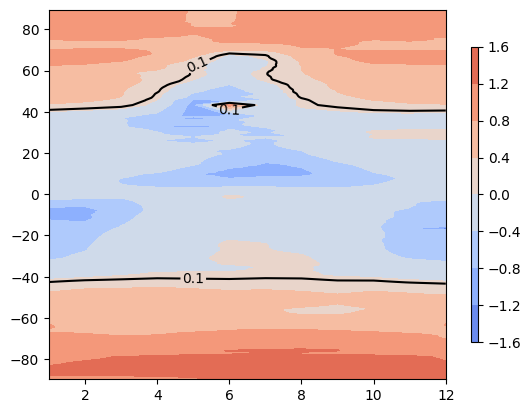

In [73]:
fig, ax = plt.subplots()

cmap = cm.coolwarm
im = ax.contourf(ML_df.month, ML_df.latitude, ML_df, cmap=cmap,vmax = 2, vmin=-2)
im1 = ax.contour(ML_df.month, ML_df.latitude, ML_df, levels = [0.1], colors='black')
ax.clabel(im1, im1.levels)

cbar = plt.colorbar(im, shrink=0.8, aspect=40)

# THIS IS THE MIYAZAKI PLOT INCLUDING LAND AND OCEAN

In [96]:
ML_df_land = land_R1.groupby('month').mean().mean('longitude').transpose()
ML_df_land = ML_df_land.where((ML_df_land < 4) & (ML_df_land > -4))
ML_df_land = ML_df_land.rolling(latitude=4, center =True).mean().dropna('latitude')

ML_df_ocean = df.R1.where(df.R1.land==0).groupby('month').mean().mean('longitude').transpose()
ML_df_ocean = ML_df_ocean.rolling(latitude=4, center =True).mean().dropna('latitude')

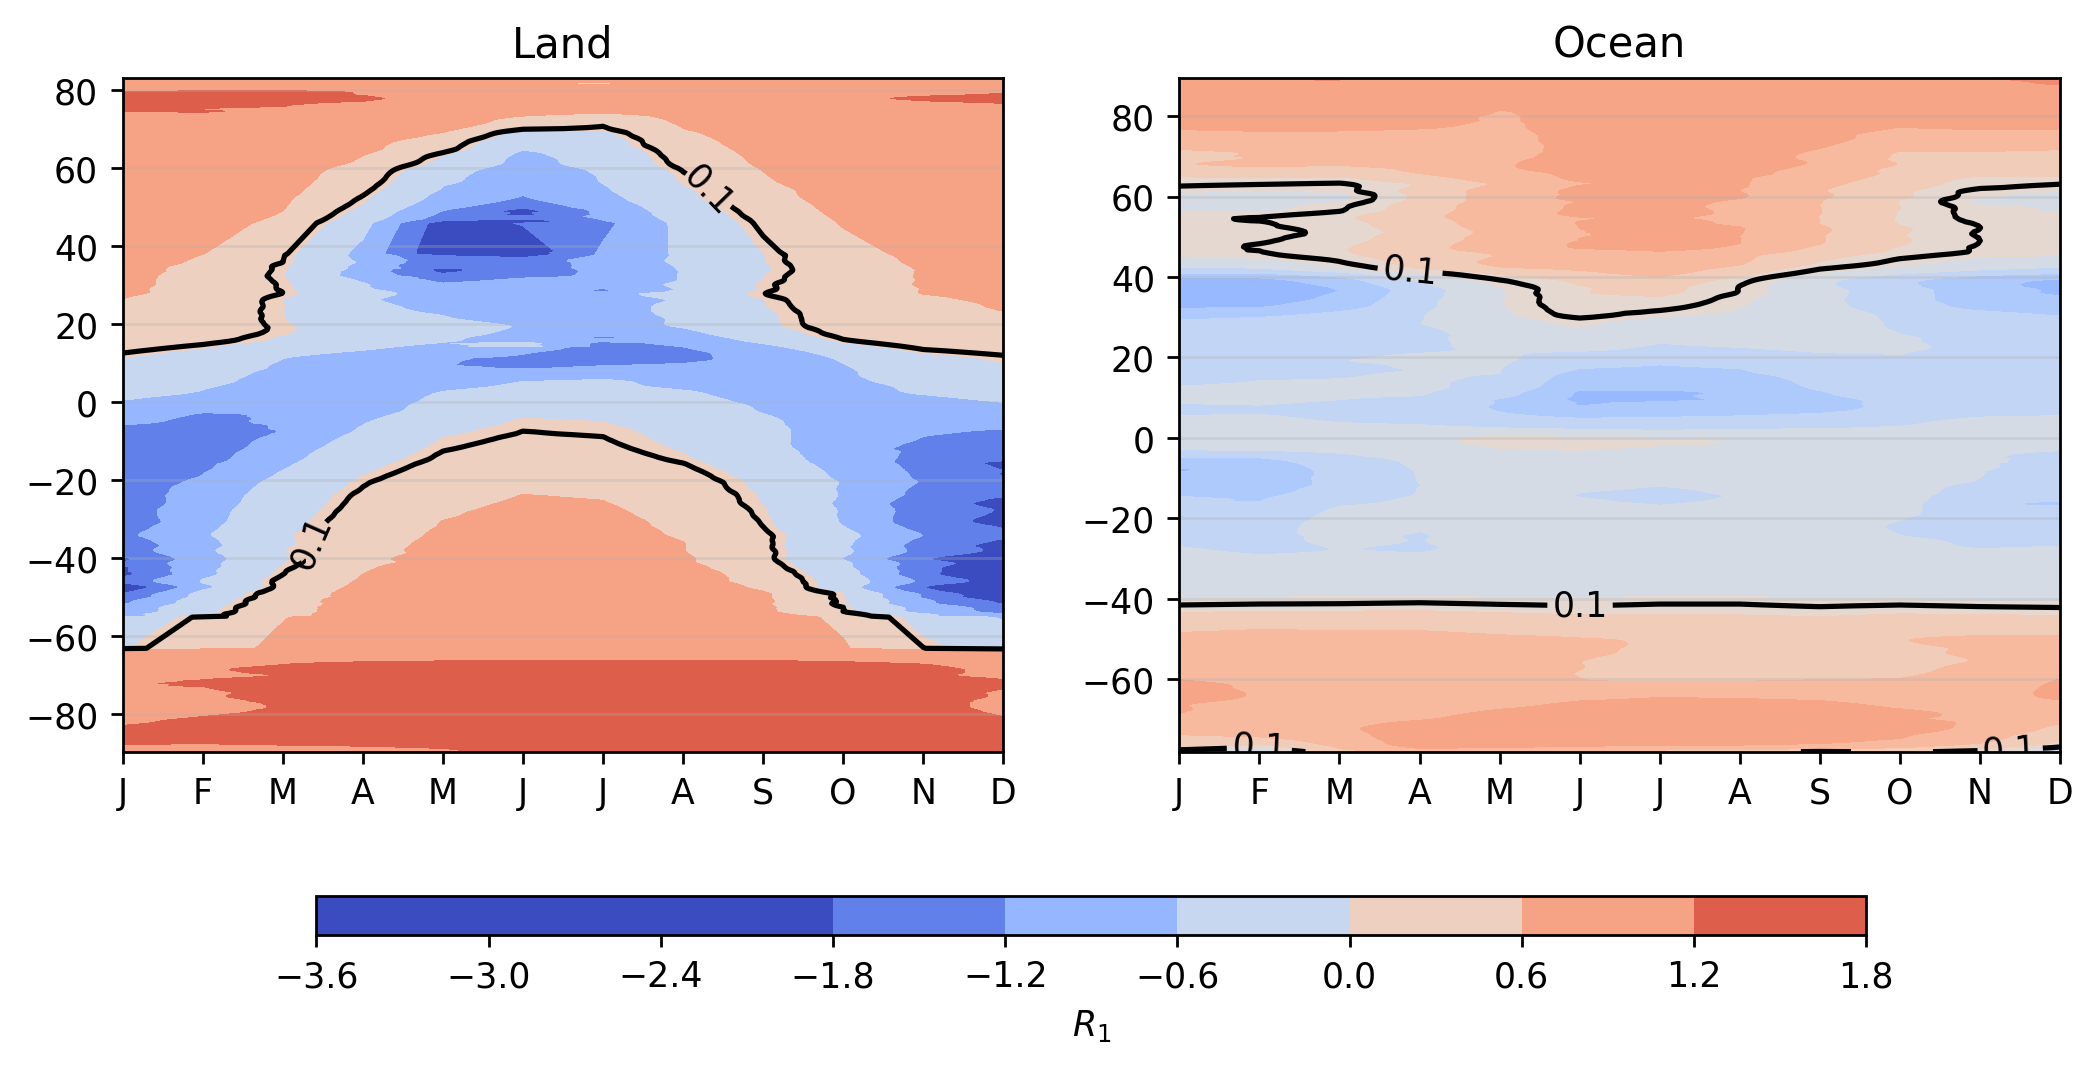

In [101]:
fig, ax = plt.subplots(1,2,figsize=(10,5),dpi=250)
cmap = cm.coolwarm
im1 = ax[0].contourf(ML_df_land.month, ML_df_land.latitude, ML_df_land, cmap=cmap, vmax = 2, vmin=-2)
im2 = ax[0].contour(ML_df_land.month, ML_df_land.latitude, ML_df_land, levels = [0.1], colors='black')
im = ax[1].contourf(ML_df_ocean.month, ML_df_ocean.latitude, ML_df_ocean, cmap=cmap, vmax = 2, vmin=-2)
im3 = ax[1].contour(ML_df_ocean.month, ML_df_ocean.latitude, ML_df_ocean, levels = [0.1], colors='black')

ax[0].clabel(im2, im2.levels)
ax[1].clabel(im3, im3.levels)

cbar = plt.colorbar(im1, ax = ax[:],orientation='horizontal',shrink=0.8, aspect=40)

ax[0].grid(axis='y',alpha=0.3)
ax[1].grid(axis='y',alpha=0.3)

ax[0].set_xticks([1,2,3,4,5,6,7,8,9,10,11,12])
ax[0].set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
ax[1].set_xticks([1,2,3,4,5,6,7,8,9,10,11,12])
ax[1].set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])

ax[0].set_title('Land')
ax[1].set_title('Ocean')

cbar.set_label(r'$R_1$')
plt.show()

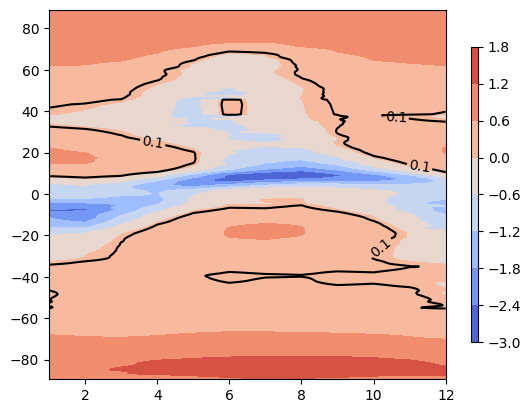

In [92]:
# Now do R1s and R1q, R1s but for divq and divs

df['R1_DSE'] = (-df.tp_watts * (3600*24) + df.sshf) / df.Q + 1
ML_df_s = df.R1_DSE.groupby('month').mean().mean('longitude').transpose()
ML_df_s = ML_df_s.where((ML_df < 4) & (ML_df > -4))
ML_df_s = ML_df_s.rolling(latitude=4, center =True).mean().dropna('latitude')

fig, ax = plt.subplots()
cmap = cm.coolwarm
im = ax.contourf(ML_df_s.month, ML_df_s.latitude, ML_df_s, cmap=cmap,vmax = 2, vmin=-3)
im1 = ax.contour(ML_df_s.month, ML_df_s.latitude, ML_df_s, levels = [0.1], colors='black')
ax.clabel(im1, im1.levels)

cbar = plt.colorbar(im, shrink=0.8, aspect=40)

In [84]:
ML_df_land_s = df.R1_DSE.where(df.R1_DSE.land==1).groupby('month').mean().mean('longitude').transpose()
ML_df_land_s = ML_df_land_s.where((ML_df_land_s < 4) & (ML_df_land_s > -4))
ML_df_land_s = ML_df_land_s.rolling(latitude=4, center =True).mean().dropna('latitude')
ML_df_ocean_s = df.R1_DSE.where(df.R1_DSE.land==0).groupby('month').mean().mean('longitude').transpose()
ML_df_ocean_s = ML_df_ocean_s.rolling(latitude=4, center =True).mean().dropna('latitude')

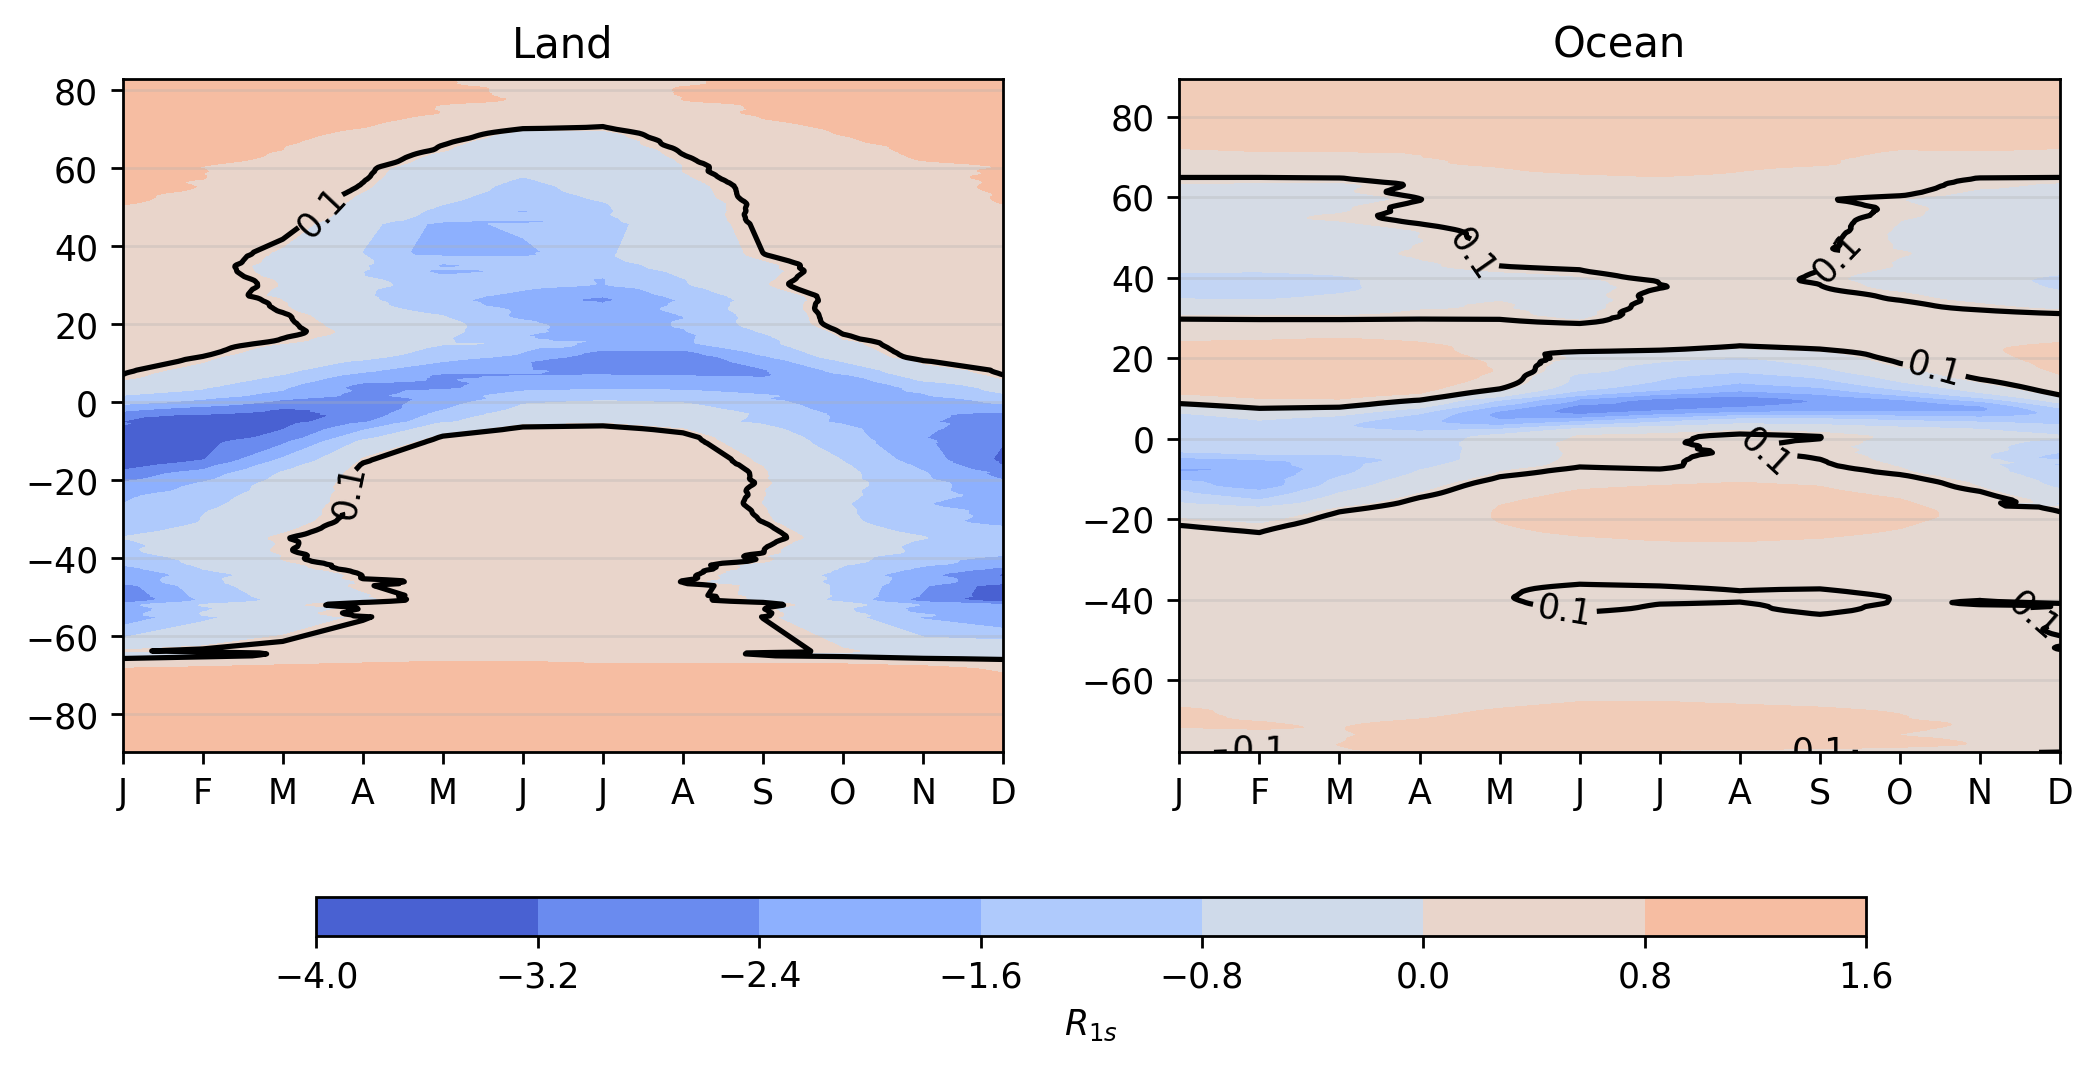

In [102]:
fig, ax = plt.subplots(1,2,figsize=(10,5),dpi=250)
cmap = cm.coolwarm
im1 = ax[0].contourf(ML_df_land_s.month, ML_df_land_s.latitude, ML_df_land_s, cmap=cmap, vmax = 4, vmin=-4)
im2 = ax[0].contour(ML_df_land_s.month, ML_df_land_s.latitude, ML_df_land_s, levels = [0.1], colors='black')
im = ax[1].contourf(ML_df_ocean_s.month, ML_df_ocean_s.latitude, ML_df_ocean_s, cmap=cmap, vmax = 4, vmin=-4)
im3 = ax[1].contour(ML_df_ocean_s.month, ML_df_ocean_s.latitude, ML_df_ocean_s, levels = [0.1], colors='black')

ax[0].clabel(im2, im2.levels)
ax[1].clabel(im3, im3.levels)

cbar = plt.colorbar(im1, ax = ax[:],orientation='horizontal',shrink=0.8, aspect=40)

ax[0].grid(axis='y',alpha=0.3)
ax[1].grid(axis='y',alpha=0.3)
ax[0].set_xticks([1,2,3,4,5,6,7,8,9,10,11,12])
ax[0].set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
ax[1].set_xticks([1,2,3,4,5,6,7,8,9,10,11,12])
ax[1].set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])

ax[0].set_title('Land')
ax[1].set_title('Ocean')

cbar.set_label(r'$R_{1s}$')
plt.show()

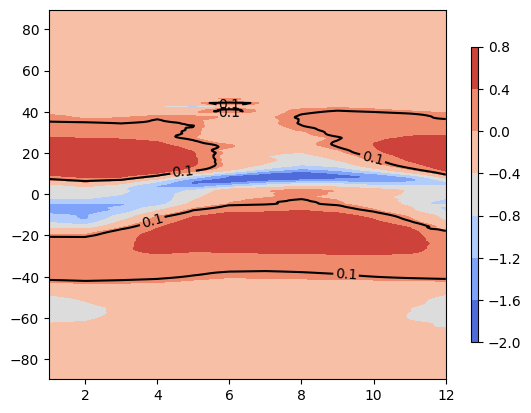

In [93]:
df['R1_q'] = df.R1_DSE - df.R1
ML_df_q = df.R1_q.groupby('month').mean().mean('longitude').transpose()
ML_df_q = ML_df_q.where((ML_df_q < 4) & (ML_df_q > -4))
ML_df_q = ML_df_q.rolling(latitude=4, center =True).mean().dropna('latitude')

fig, ax = plt.subplots()
cmap = cm.coolwarm
im = ax.contourf(ML_df_q.month, ML_df_q.latitude, ML_df_q, cmap=cmap)
im1 = ax.contour(ML_df_q.month, ML_df_q.latitude, ML_df_q, levels = [0.1], colors='black')
ax.clabel(im1, im1.levels)

cbar = plt.colorbar(im, shrink=0.8, aspect=40)

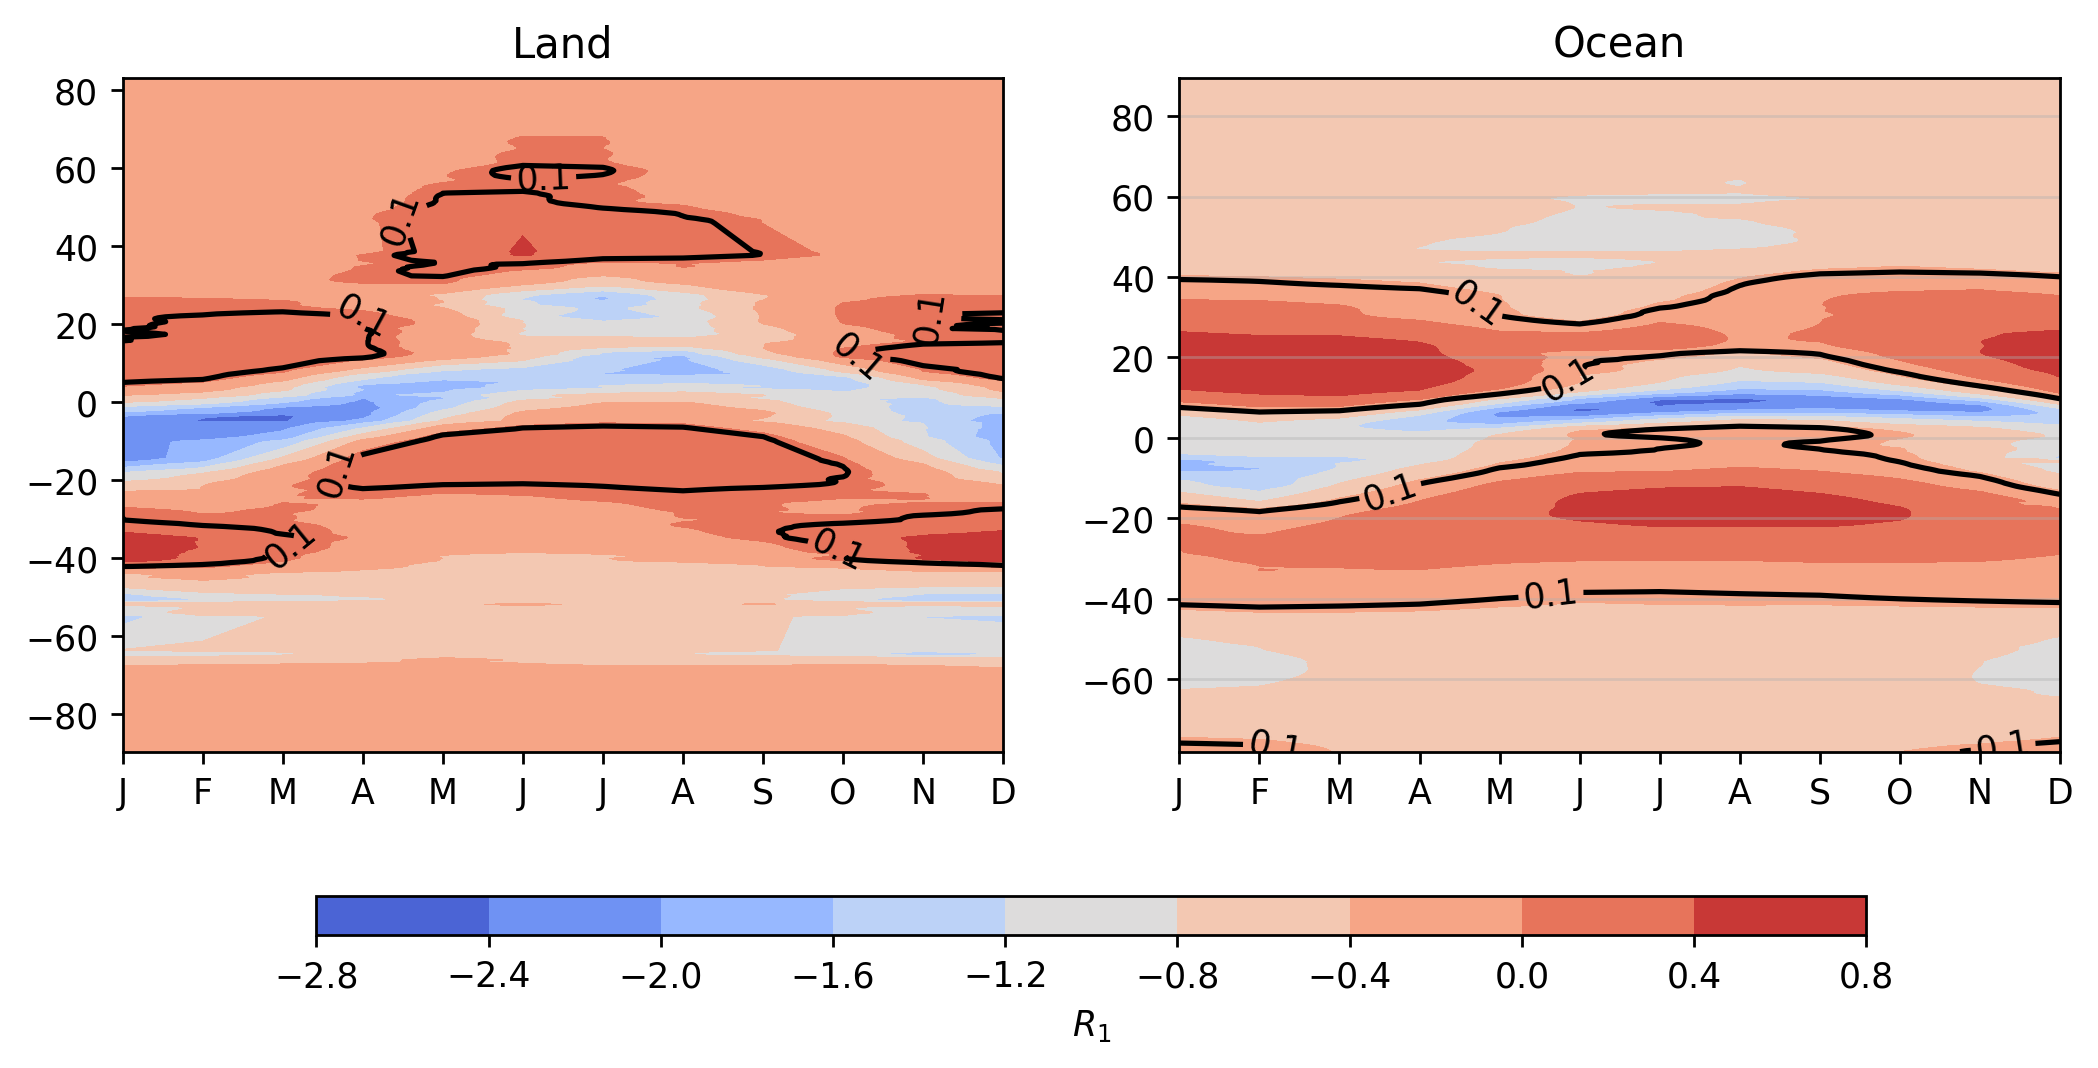

In [98]:
ML_df_land_q = ML_df_land_s - ML_df_land
ML_df_ocean_q = ML_df_ocean_s - ML_df_ocean

fig, ax = plt.subplots(1,2,figsize=(10,5),dpi=250)
cmap = cm.coolwarm
im1 = ax[0].contourf(ML_df_land_q.month, ML_df_land_q.latitude, ML_df_land_q, cmap=cmap)
im2 = ax[0].contour(ML_df_land_q.month, ML_df_land_q.latitude, ML_df_land_q, levels = [0.1], colors='black')
im = ax[1].contourf(ML_df_ocean_q.month, ML_df_ocean_q.latitude, ML_df_ocean_q, cmap=cmap)
im3 = ax[1].contour(ML_df_ocean_q.month, ML_df_ocean_q.latitude, ML_df_ocean_q, levels = [0.1], colors='black')

ax[0].clabel(im2, im2.levels)
ax[1].clabel(im3, im3.levels)

cbar = plt.colorbar(im1, ax = ax[:],orientation='horizontal',shrink=0.8, aspect=40)

ax[0].grid(axis='y',alpha=0.3)
ax[1].grid(axis='y',alpha=0.3)
ax[0].set_xticks([1,2,3,4,5,6,7,8,9,10,11,12])
ax[0].set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
ax[1].set_xticks([1,2,3,4,5,6,7,8,9,10,11,12])
ax[1].set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])

ax[0].set_title('Land')
ax[1].set_title('Ocean')

cbar.set_label(r'$R_{1q}$')
plt.show()

### Coarsenesses

In [ ]:
avg_land_R1 = df.R1_mw.where(df.isel(date=0).land==1).mean('date')

In [ ]:
# df_coarse = df[['slhf_w','sshf_w','Q_w']].rolling(latitude = 50, longitude=50).mean()
# df_coarse['R1_w'] = 1+(df_coarse['slhf_w'] + df_coarse['sshf_w']) / df_coarse['Q_w'] 
# to do rolling should parallelize (multiple cores etc.) otherwise it takes too long.

df_coarse = df[['slhf_w','sshf_w','Q_w']].coarsen(latitude = 100, longitude=100, boundary='pad').mean()
df_coarse['R1_w'] = 1+(df_coarse['slhf_w'] + df_coarse['sshf_w']) / df_coarse['Q_w'] 

In [ ]:
time = df['date'].to_index()
days_per_month = time.to_series().apply(lambda x: pd.to_datetime(x, format = '%Y%m%d').days_in_month * 12 / (365 + pd.to_datetime(x, format = '%Y%m%d').is_leap_year))
day_weights = xr.DataArray(
    days_per_month.values,
    coords={"date": df["date"]},
    dims=["date"]
)

df_coarse['slhf_mw'] = day_weights * df_coarse.slhf_w
df_coarse['Q_mw'] = day_weights * df_coarse.Q_w
df_coarse['sshf_mw'] = day_weights * df_coarse.sshf_w
df_coarse['R1_mw'] = 1 + (df_coarse.slhf_mw + df_coarse.sshf_mw) / df_coarse.Q_mw

df_coarse_mean = df_coarse.mean('date')

In [ ]:
fig, ax = plt.subplots(2, figsize=(20,10), subplot_kw = {'projection':ccrs.PlateCarree()})
# ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())
im = ax[0].pcolormesh(df_coarse_mean.longitude, df_coarse_mean.latitude,
                   df_coarse_mean.R1_mw, transform=ccrs.PlateCarree(),vmin = -1, vmax = 1)

# Add coast- and gridlines
ax[0].coastlines(color='black')
gl = ax[0].gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False


im1 = ax[1].pcolormesh(df.longitude, df.latitude,
                   df.R1_mw.mean('date'), transform=ccrs.PlateCarree(),vmin = -1, vmax = 1)

# Add coast- and gridlines
ax[1].coastlines(color='black')
gl = ax[1].gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')

# Add title and legend
#ax.set_title(f'R1 = 1+(LH+SH)/Q average for 1980. Grid sizes are 0.25 deg lat and long', fontsize=24)

cbar = fig.colorbar(im, ax=ax[:], fraction=0.046, pad=0.04)
cbar.set_label('\n R1 (unitless)',fontsize=20)
# plt.savefig('./Plots/R1_1980_world.png')

## Getting Fractions in RCE

it is now weighted by length of month ('R1_mw')

In [ ]:
# Averaged over all time, then R1 calculated

fig = plt.figure(figsize=(20,10))
ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())

im = plt.pcolormesh(Mean_R1_df.longitude, Mean_R1_df.latitude,
                    Mean_R1_df, transform=ccrs.PlateCarree(), vmin=-1, vmax = 1)

im2 = plt.contour(Mean_R1_df.longitude, Mean_R1_df.latitude,
                    Mean_R1_df, transform=ccrs.PlateCarree(), levels=[0.1], colors = 'red')

# Add coast- and gridlines
ax.coastlines(color='black')
gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Add title and legend
#ax.set_title(f'R1 = 1+(LH+SH)/Q average for 1980. Grid sizes are 0.25 deg lat and long', fontsize=24)

cbar = plt.colorbar(im,fraction=0.046, pad=0.04)
cbar.set_label('\n R1 (unitless)',fontsize=20)
# plt.savefig('./Plots/R1_1980_world.png')

In [ ]:
Mean_R1_df = df.R1_mw.mean('date')

In [ ]:
# R1_data_mean = df.R1
RCE_mean_data = (Mean_R1_df <= 0.1)

# Sanity check, run the following line for RCE threshold of 10, and it should approach 1, -10 and should approach 0

frac_RCE_total = sum(RCE_mean_data.mean(dim='longitude') * 2 * np.pi * R * np.cos(df.latitude*np.pi/180) * 0.25 * np.pi/180 * R)/earth_area_total

In [ ]:
R1_wLand = Mean_R1_df.where(df.isel(date=0).land == 1)
R1_wOcean = Mean_R1_df.where(df.isel(date=0).land == 0)

In [ ]:
# Calculate total land area 
land_area = sum(R1_wLand.land.mean(dim='longitude') * 2 * np.pi * R * np.cos(df.latitude*np.pi/180) * 0.25 * np.pi/180 * R)
ocean_area = earth_area_total - land_area

In [ ]:
# Frac RCE just land 
RCE_mean_data_land = (R1_wLand <= 0.1)
frac_RCE_land = sum(RCE_mean_data_land.mean(dim='longitude') * 2 * np.pi * R * np.cos(df.latitude*np.pi/180) * 0.25 * np.pi/180 * R)/land_area

In [ ]:
# Frac RCE just ocean
RCE_mean_data_ocean = (R1_wOcean <= 0.1)
frac_RCE_ocean = sum(RCE_mean_data_ocean.mean(dim='longitude') * 2 * np.pi * R * np.cos(df.latitude*np.pi/180) * 0.25 * np.pi/180 * R)/ocean_area

In [ ]:
# Area of habitable land (land excluding antarctica)
Hland = df.land.isel(date=0).where((df.isel(date=0).latitude > -60) & (df.isel(date=0).land == 1))
Hland_area = sum(Hland.fillna(0).mean(dim='longitude') * 2 * np.pi * R * np.cos(df.latitude*np.pi/180) * 0.25 * np.pi/180 * R)

In [ ]:
# Frac RCE Habitable land (Excluding antarctica) 
HLand_R1 = Mean_R1_df.where((df.isel(date=0).land == 1) & (df.isel(date=0).latitude > - 60))
RCE_Hland = (HLand_R1 <= 0.1)
frac_RCE_Hland = sum(RCE_Hland.mean(dim='longitude') * 2 * np.pi * R * np.cos(df.latitude*np.pi/180) * 0.25 * np.pi/180 * R)/Hland_area

In [ ]:
# Calculating land area within 30, 45, and 60 degs

land30 = df.land.isel(date=0).where((df.isel(date=0).latitude >= -30) & (df.isel(date=0).latitude <= 30) & (df.isel(date=0).land == 1))
land30_area = sum(land30.fillna(0).mean(dim='longitude') * 2 * np.pi * R * np.cos(df.latitude*np.pi/180) * 0.25 * np.pi/180 * R)

land45 = df.land.isel(date=0).where((df.isel(date=0).latitude >= -45) & (df.isel(date=0).latitude <= 45) & (df.isel(date=0).land == 1))
land45_area = sum(land45.fillna(0).mean(dim='longitude') * 2 * np.pi * R * np.cos(df.latitude*np.pi/180) * 0.25 * np.pi/180 * R)

land60 = df.land.isel(date=0).where((df.isel(date=0).latitude >= -60) & (df.isel(date=0).latitude <= 60) & (df.isel(date=0).land == 1))
land60_area = sum(land60.fillna(0).mean(dim='longitude') * 2 * np.pi * R * np.cos(df.latitude*np.pi/180) * 0.25 * np.pi/180 * R)

In [ ]:
Land_R1_30 = Mean_R1_df.where((df.isel(date=0).land == 1) & (df.isel(date=0).latitude >= - 30) & (df.isel(date=0).latitude <= 30))
RCE_land_30 = (Land_R1_30 <= 0.1)

sum(RCE_land_30.mean(dim='longitude') * 2 * np.pi * R * np.cos(df.latitude*np.pi/180) * 0.25 * np.pi/180 * R)/land30_area

In [ ]:
Land_R1_45 = Mean_R1_df.where((df.isel(date=0).land == 1) & (df.isel(date=0).latitude >= - 45) & (df.isel(date=0).latitude <= 45))
RCE_land_45 = (Land_R1_45 <= 0.1)

sum(RCE_land_45.mean(dim='longitude') * 2 * np.pi * R * np.cos(df.latitude*np.pi/180) * 0.25 * np.pi/180 * R)/land45_area

In [ ]:
Land_R1_60 = Mean_R1_df.where((df.isel(date=0).land == 1) & (df.isel(date=0).latitude >= - 60) & (df.isel(date=0).latitude <= 60))
RCE_land_60 = (Land_R1_60 <= 0.1)

sum(RCE_land_60.mean(dim='longitude') * 2 * np.pi * R * np.cos(df.latitude*np.pi/180) * 0.25 * np.pi/180 * R)/land60_area

### Population Data

citation:
Center For International Earth Science Information Network-CIESIN-Columbia University. (2018). Gridded Population of the World, Version 4 (GPWv4): Population Count Adjusted to Match 2015 Revision of UN WPP Country Totals, Revision 11 (Version 4.11) [Data set]. Palisades, NY: NASA Socioeconomic Data and Applications Center (SEDAC). https://doi.org/10.7927/H4PN93PB

In [ ]:
pop_df = xr.open_dataset('/n/holystore01/LABS/mccoll_lab/Lab/amatthews/Data/pop_map_data.nc')
pop_df = pop_df.rename(name_dict={'UN WPP-Adjusted Population Count, v4.11 (2000, 2005, 2010, 2015, 2020): 15 arc-minutes':
                         'pop'})
pop_df20 = pop_df.isel(raster=4)

In [ ]:
R1_rolled = Mean_R1_df.rolling(longitude=2,latitude=2).mean()
# R1_rolled[:,0] = (Mean_R1_df[:,0] + Mean_R1_df[:,1439])/2
R1_rolled['longitude'] = np.concatenate((np.arange(0,180,0.25),np.arange(-180,0,0.25)))
R1_rolled['longitude'] = R1_rolled.longitude - 0.125
R1_rolled['latitude'] = R1_rolled.latitude - 0.125
merged = xr.merge((pop_df20, R1_rolled))

In [ ]:
merged.where(merged.R1_mw <= 0.1).pop.sum()/pop_df20.pop.sum()

In [ ]:
np.abs(df.Q).mean()

In [ ]:
np.abs(df.slhf).mean()

In [ ]:
np.abs(df.sshf).mean()

In [ ]:
df['RCE'] = df.R1 <= 0.1 # RCE column tells if a given month, lat, lon is in RCE as we have defined it.

prop_RCE = (df[['RCE']] * day_weights).mean('date') # * day_weights weights by length of month (not by length of year but thats a negligible change
prop_rolled = prop_RCE.rolling(longitude=2,latitude=2).mean()
prop_rolled['longitude'] = np.concatenate((np.arange(0,180,0.25),np.arange(-180,0,0.25)))
prop_rolled['longitude'] = prop_rolled.longitude - 0.125
prop_rolled['latitude'] = prop_rolled.latitude - 0.125

merged = xr.merge((merged, prop_rolled))

In [ ]:
def frac_people(df, frac_time):
    # input: df = data frame with 'RCE' (binary) and 'pop' columns,  frac_time = threshold for frac of time in RCE (0-1)
    # output: fraction of people living in 'RCE' at least that fraction of time
    return df.where(df.RCE >= frac_time).pop.sum()/df.pop.sum()

In [ ]:
frac_people(merged, 0.40)

In [ ]:
N = 100
frac_time_arr = np.linspace(0,1,N)
frac_ppl_arr = np.zeros(N)
for i in range(N):
    frac_ppl_arr[i] = frac_people(merged, frac_time_arr[i])

In [ ]:
fig, ax = plt.subplots()
ax.plot(frac_time_arr, frac_ppl_arr)
plt.gca().invert_xaxis()
ax.set_ylabel("Frac People")
ax.set_xlabel("Frac Time in RCE")
plt.show()

In [ ]:
fig = plt.figure(figsize=(20,10))
ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())

im = plt.pcolormesh(pop_df20.longitude, pop_df20.latitude,
                    pop_df20.pop, transform=ccrs.PlateCarree(),vmin=0,vmax=50000)

# Add coast- and gridlines
ax.coastlines(color='black')
gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

cbar = plt.colorbar(im,fraction=0.046, pad=0.04)
cbar.set_label('Population',fontsize=20)
# plt.savefig('./Plots/R1_1980_world.png')

### Proportions in RCE

In [ ]:
df['RCE'] = df.R1 <= 0.1 # RCE column tells if a given month, lat, lon is in RCE as we have defined it.
prop_RCE = (df.RCE * day_weights).mean('date') # * day_weights weights by length of month (not by length of year but thats a negligible change
prop_RCE_land = prop_RCE.where(df.isel(date=0).land==1,drop=True) 
prop_RCE_ocean = prop_RCE.where(df.isel(date=0).land!=1,drop=True)

In [ ]:
prop_RCE_avg = get_frac(prop_RCE)
prop_RCE_land_avg = get_frac(prop_RCE_land)
prop_RCE_ocean_avg = get_frac(prop_RCE_ocean)
print(float(prop_RCE_avg))
print(float(prop_RCE_land_avg))
print(float(prop_RCE_ocean_avg))

In [ ]:
prop_RCE_30_avg = get_frac(prop_RCE, -30, 30)
prop_RCE_land_30_avg =  get_frac(prop_RCE_land, -30, 30)
prop_RCE_ocean_30_avg = get_frac(prop_RCE_ocean, -30, 30)
prop_RCE_land_60_avg = get_frac(prop_RCE_land, -60, 60)
print(float(prop_RCE_30_avg))
print(float(prop_RCE_land_30_avg))
print(float(prop_RCE_ocean_30_avg))
print(float(prop_RCE_land_60_avg))

In [ ]:
# Averaged over all time, then R1 calculated

fig = plt.figure(figsize=(20,10))
ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())

im = plt.pcolormesh(prop_RCE.longitude, prop_RCE.latitude,
                    prop_RCE, transform=ccrs.PlateCarree())

# Add coast- and gridlines
ax.coastlines(color='black')
gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Add title and legend
#ax.set_title(f'R1 = 1+(LH+SH)/Q average for 1980. Grid sizes are 0.25 deg lat and long', fontsize=24)

cbar = plt.colorbar(im,fraction=0.046, pad=0.04)
cbar.set_label('Frac Time RCE',fontsize=20)
# plt.savefig('./Plots/R1_1980_world.png')

In [ ]:
fig, ax = plt.subplots()
ax.plot(prop_RCE_ocean.latitude, prop_RCE_ocean.mean('longitude'),label='ocean')
ax.plot(prop_RCE_land.latitude, prop_RCE_land.mean('longitude'),label='land')
ax.plot(prop_RCE.latitude, prop_RCE.mean('longitude'),label='total')

ax.set_ylabel("Frac time in RCE")
ax.set_xlabel("Latitude")
ax.legend()
plt.show()

### Seasonal

For now, 
summer = june july august
winter = december january february

In [ ]:
R1_summer = df.R1.where((df.R1.month < 9) & (df.R1.month > 5) & (df.isel(date=0).R1.land)).mean('date')
RCE_summer = (R1_summer <= 0.1)
frac_RCE_summer = sum(RCE_summer.mean(dim='longitude') * 2 * np.pi * R * np.cos(df.latitude*np.pi/180) * 0.25 * np.pi/180 * R)/land_area

In [ ]:
landNH= df.land.isel(date=0).where((df.isel(date=0).latitude >= 0) & (df.isel(date=0).land == 1))
landNH_area = sum(landNH.fillna(0).mean(dim='longitude') * 2 * np.pi * R * np.cos(df.latitude*np.pi/180) * 0.25 * np.pi/180 * R)

landNH_H = df.land.isel(date=0).where((df.isel(date=0).latitude >= 0) & (df.isel(date=0).latitude <= 60) & (df.isel(date=0).land == 1))
landNH_area_H = sum(landNH_H.fillna(0).mean(dim='longitude') * 2 * np.pi * R * np.cos(df.latitude*np.pi/180) * 0.25 * np.pi/180 * R)

landSH= df.land.isel(date=0).where((df.isel(date=0).latitude <= 0) & (df.isel(date=0).land == 1))
landSH_area = sum(landSH.fillna(0).mean(dim='longitude') * 2 * np.pi * R * np.cos(df.latitude*np.pi/180) * 0.25 * np.pi/180 * R)

landSH_H = df.land.isel(date=0).where((df.isel(date=0).latitude <= 0) & (df.isel(date=0).latitude >= -60) & (df.isel(date=0).land == 1))
landSH_H_area = sum(landSH_H.fillna(0).mean(dim='longitude') * 2 * np.pi * R * np.cos(df.latitude*np.pi/180) * 0.25 * np.pi/180 * R)

In [ ]:
R1_summer_NH = df.R1.where((df.R1.month < 9) & (df.R1.month > 5) & (df.isel(date=0).R1.land) & (df.isel(date=0).latitude >= 0)).mean('date')
RCE_summer_NH = (R1_summer_NH <= 0.1)
frac_RCE_summer_NH = sum(RCE_summer_NH.mean(dim='longitude') * 2 * np.pi * R * np.cos(df.latitude*np.pi/180) * 0.25 * np.pi/180 * R)/landNH_area

In [ ]:
R1_summer_NH_H = df.R1.where((df.R1.month < 9) & (df.R1.month > 5) & (df.isel(date=0).R1.land) & (df.isel(date=0).latitude >= 0)& (df.isel(date=0).latitude <= 60)).mean('date')
RCE_summer_NH_H = (R1_summer_NH_H <= 0.1)
frac_RCE_summer_NH_H = sum(RCE_summer_NH_H.mean(dim='longitude') * 2 * np.pi * R * np.cos(df.latitude*np.pi/180) * 0.25 * np.pi/180 * R)/landNH_area_H

In [ ]:
frac_RCE_summer_NH_H

In [ ]:
R1_winter = df.R1.where((df.R1.month.isin([12,1,2])) & (df.isel(date=0).R1.land)).mean('date')
RCE_winter = (R1_winter <= 0.1)
frac_RCE_winter = sum(RCE_winter.mean(dim='longitude') * 2 * np.pi * R * np.cos(df.latitude*np.pi/180) * 0.25 * np.pi/180 * R)/land_area

In [ ]:
R1_winter_SH = df.R1.where((df.R1.month.isin([12,1,2])) & (df.isel(date=0).R1.land) & (df.isel(date=0).latitude <= 0)).mean('date')
RCE_winter_SH = (R1_winter_SH <= 0.1)
frac_RCE_winter_SH = sum(RCE_winter_SH.mean(dim='longitude') * 2 * np.pi * R * np.cos(df.latitude*np.pi/180) * 0.25 * np.pi/180 * R)/landSH_area

In [ ]:
R1_winter_SH_H = df.R1.where((df.R1.month.isin([12,1,2])) & (df.isel(date=0).R1.land) & (df.isel(date=0).latitude <= 0)& (df.isel(date=0).latitude >= -60)).mean('date')
RCE_winter_SH_H = (R1_winter_SH_H <= 0.1)
frac_RCE_winter_SH_H = sum(RCE_winter_SH_H.mean(dim='longitude') * 2 * np.pi * R * np.cos(df.latitude*np.pi/180) * 0.25 * np.pi/180 * R)/landSH_H_area

In [ ]:
frac_RCE_winter_SH_H

In [ ]:
# Averaged over all time, then R1 calculated

fig = plt.figure(figsize=(20,10))
ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())

im = plt.pcolormesh(R1_summer.longitude, R1_summer.latitude,
                    R1_summer, vmin=-2, vmax = 2, transform=ccrs.PlateCarree())

im2 = plt.contour(R1_summer.longitude, R1_summer.latitude,
                    R1_summer, transform=ccrs.PlateCarree(), levels=[0.1],colors='red')

# Add coast- and gridlines
ax.coastlines(color='black')
gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Add title and legend
#ax.set_title(f'R1 = 1+(LH+SH)/Q average for 1980. Grid sizes are 0.25 deg lat and long', fontsize=24)

cbar = plt.colorbar(im,fraction=0.046, pad=0.04)
cbar.set_label('R1',fontsize=20)
# plt.savefig('./Plots/R1_1980_world.png')

## DSE, MSE, q, stuff

### Plots of divs

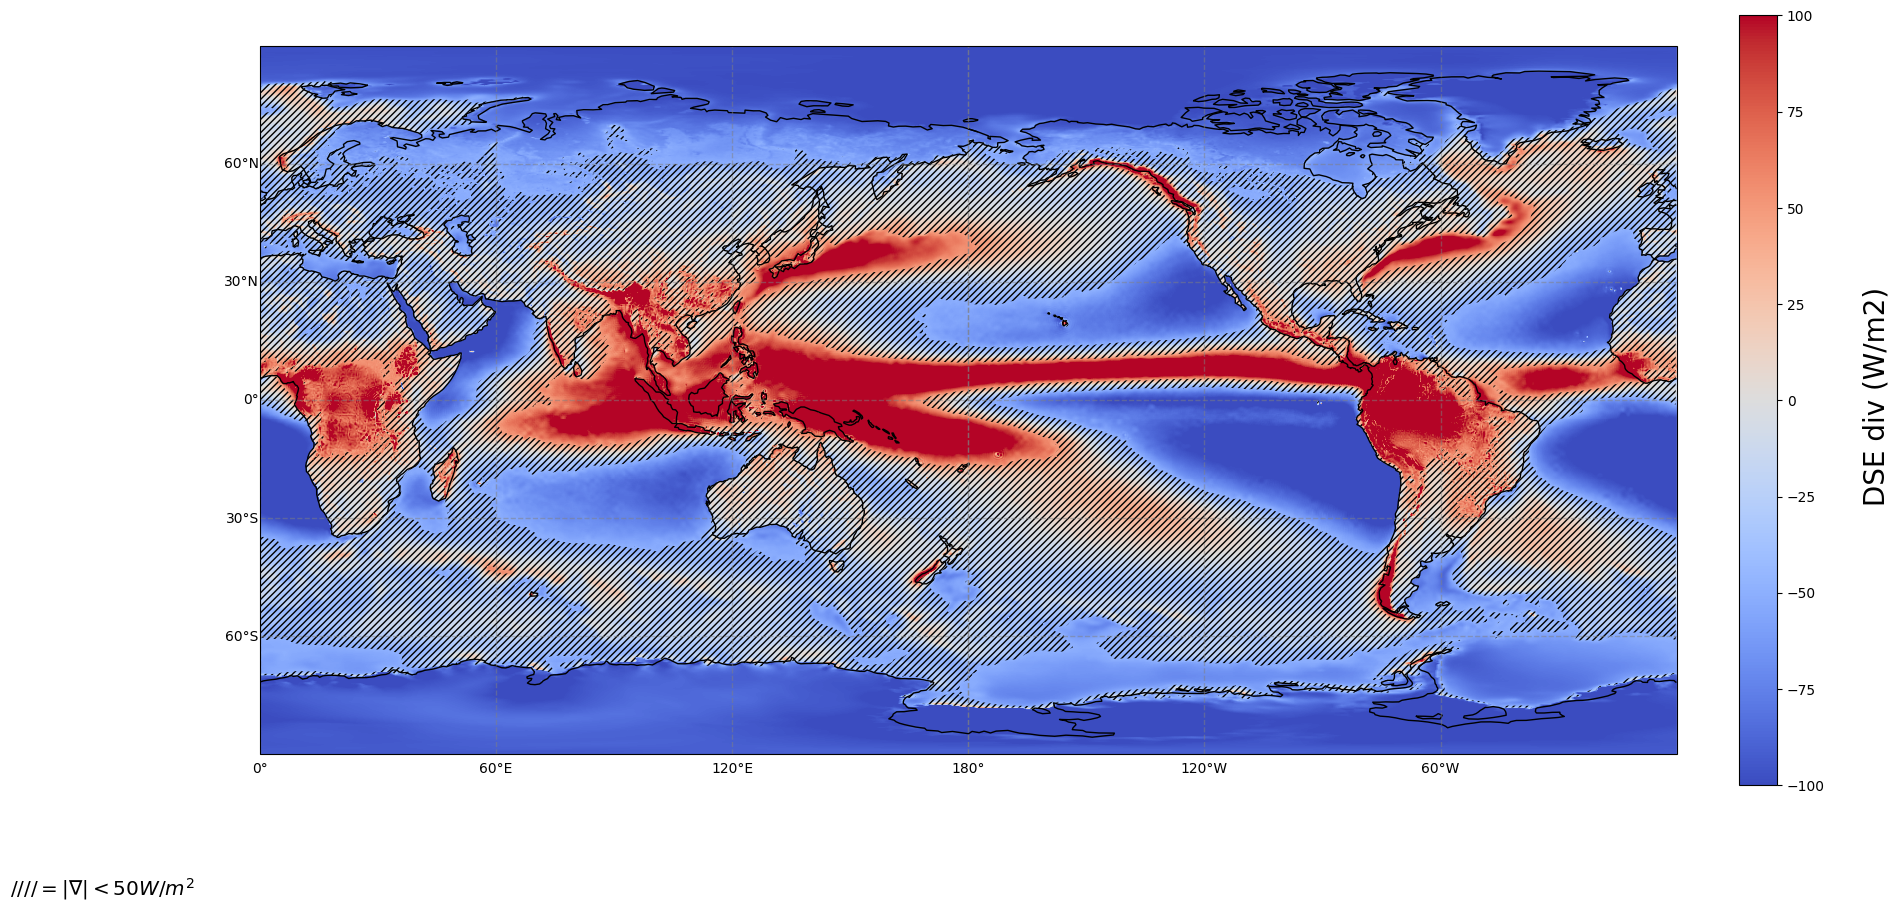

In [7]:
# Averaged over all time, then R1 calculated
fig = plt.figure(figsize=(20,10))
ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree(central_longitude=180))

cmap = cm.coolwarm
im = plt.pcolormesh(df.longitude, 
                    df.latitude,
                    df.divDSE_mw.mean('date'), 
                    transform=ccrs.PlateCarree(), vmin=-100, vmax=100, cmap=cmap)

im2 = plt.contourf(df.longitude, 
                    df.latitude,
                    df.divDSE_mw.mean('date'), 
                    transform=ccrs.PlateCarree(), levels = [-50,50], hatches = [5*'/',''],colors='none')

fig.text(0,0,r"$ //// = |\nabla| < 50 W/m^2$",fontsize='x-large')

# Add coast- and gridlines
ax.coastlines(color='black')
gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# ax.clabel(im2, im2.levels)

# Add title and legend
#ax.set_title(f'R1 = 1+(LH+SH)/Q average for 1980. Grid sizes are 0.25 deg lat and long', fontsize=24)

cbar = plt.colorbar(im,fraction=0.046, pad=0.04)
cbar.set_label('\n DSE div (W/m2)',fontsize=20)
# plt.savefig('./Plots/R1_1980_world.png')

In [ ]:
# Averaged over all time, then R1 calculated
fig = plt.figure(figsize=(20,10))
ax = plt.subplot(1,1,1, projection=ccrs.Robinson(central_longitude=180))

cmap = cm.coolwarm
im = plt.pcolormesh(df.longitude, df.latitude,
                    -(df.Q_mw.mean('date') + df.sshf_mw.mean('date') + df.slhf_mw.mean('date'))/(3600*24), 
                    transform=ccrs.PlateCarree(), vmin=-360, vmax=360, cmap=cmap)


# im2 = plt.contour(df.longitude, df.latitude,
#                     -(df.tp_watts.mean('date') + (df.Q_mw.mean('date') + df.sshf_mw.mean('date'))/(3600*24)), 
#                     transform=ccrs.PlateCarree(), levels=[-50,50],colors='black')


# im2 = plt.contour(Mean_R1_df.longitude, Mean_R1_df.latitude,
#                     Mean_R1_df, transform=ccrs.PlateCarree(), levels=[0.1], colors = 'red')

# Add coast- and gridlines
ax.coastlines(color='black')
gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# ax.clabel(im2, im2.levels)

# Add title and legend
#ax.set_title(f'R1 = 1+(LH+SH)/Q average for 1980. Grid sizes are 0.25 deg lat and long', fontsize=24)

cbar = plt.colorbar(im,fraction=0.046, pad=0.04)
cbar.set_label('\n MSE div (W/m2)',fontsize=20)
# plt.savefig('./Plots/R1_1980_world.png')

In [ ]:
# Averaged over all time, then R1 calculated
fig, ax = plt.subplots(3, figsize=(20,30), subplot_kw = {'projection':ccrs.Robinson(central_longitude=180)})

cmap = cm.coolwarm

im1 = ax[0].pcolormesh(df.longitude, df.latitude,
                    df.divMSE_mw.mean('date'), 
                    transform=ccrs.PlateCarree(), vmin=-100, vmax=100, cmap=cmap)

im2 = ax[1].pcolormesh(df.longitude, df.latitude,
                    df.divDSE_mw.mean('date'), 
                    transform=ccrs.PlateCarree(), vmin=-100, vmax=100, cmap=cmap)

im3 = ax[2].pcolormesh(df.longitude, df.latitude,
                    df.divq_mw.mean('date'), 
                    transform=ccrs.PlateCarree(), vmin=-100, vmax=100, cmap=cmap)


im4 = ax[0].contourf(df.longitude, 
                    df.latitude,
                    df.divMSE_mw.mean('date'), 
                    transform=ccrs.PlateCarree(), levels = [-50,50], hatches = [5*'/',''],colors='none')
im5 = ax[1].contourf(df.longitude, 
                    df.latitude,
                    df.divDSE_mw.mean('date'), 
                    transform=ccrs.PlateCarree(), levels = [-50,50], hatches = [5*'/',''],colors='none')
im6 = ax[2].contourf(df.longitude, 
                    df.latitude,
                    df.divq_mw.mean('date'), 
                    transform=ccrs.PlateCarree(), levels = [-50,50], hatches = [5*'/',''],colors='none')


# Add coast- and gridlines
ax[0].coastlines(color='black')
ax[1].coastlines(color='black')
ax[2].coastlines(color='black')

gl = ax[0].gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl = ax[1].gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl = ax[2].gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')

gl.top_labels = False
gl.right_labels = False

ax[0].set_title("div MSE",fontsize=20)
ax[1].set_title("div DSE",fontsize=20)
ax[2].set_title(r"div q/$\lambda$",fontsize=20)

# ax.clabel(im2, im2.levels)

# Add title and legend
#ax.set_title(f'R1 = 1+(LH+SH)/Q average for 1980. Grid sizes are 0.25 deg lat and long', fontsize=24)

cbar = plt.colorbar(im,ax=ax[:],fraction=0.046, pad=0.04)
cbar.set_label('\n Power Balance (W/m2)',fontsize=20)
# plt.savefig('./Plots/R1_1980_world.png')

In [ ]:
# Seasonally, just summer months (6,7,8)

MSE_summer = df.divMSE_mw.where((df.month > 5) & (df.month < 9)).mean('date')
DSE_summer = df.divDSE_mw.where((df.month > 5) & (df.month < 9)).mean('date')
q_summer = df.divq_mw.where((df.month > 5) & (df.month < 9)).mean('date')


In [ ]:
# Averaged over all time, then R1 calculated
fig, ax = plt.subplots(3, figsize=(20,30), subplot_kw = {'projection':ccrs.Robinson(central_longitude=180)})

cmap = cm.coolwarm

im1 = ax[0].pcolormesh(df.longitude, df.latitude,
                    MSE_summer, 
                    transform=ccrs.PlateCarree(), vmin=-100, vmax=100, cmap=cmap)

im2 = ax[1].pcolormesh(df.longitude, df.latitude,
                    DSE_summer, 
                    transform=ccrs.PlateCarree(), vmin=-100, vmax=100, cmap=cmap)

im3 = ax[2].pcolormesh(df.longitude, df.latitude,
                    q_summer, 
                    transform=ccrs.PlateCarree(), vmin=-100, vmax=100, cmap=cmap)

im4 = ax[0].contourf(df.longitude, 
                    df.latitude,
                    MSE_summer, 
                    transform=ccrs.PlateCarree(), levels = [-50,50], hatches = [5*'/',''],colors='none')
im5 = ax[1].contourf(df.longitude, 
                    df.latitude,
                    DSE_summer, 
                    transform=ccrs.PlateCarree(), levels = [-50,50], hatches = [5*'/',''],colors='none')
im6 = ax[2].contourf(df.longitude, 
                    df.latitude,
                    q_summer, 
                    transform=ccrs.PlateCarree(), levels = [-50,50], hatches = [5*'/',''],colors='none')


# Add coast- and gridlines
ax[0].coastlines(color='black')
ax[1].coastlines(color='black')
ax[2].coastlines(color='black')

gl = ax[0].gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

gl = ax[1].gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

gl = ax[2].gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

ax[0].set_title("div MSE",fontsize=20)
ax[1].set_title("div DSE",fontsize=20)
ax[2].set_title(r"div q/$\lambda$",fontsize=20)

# ax.clabel(im2, im2.levels)

# Add title and legend
#ax.set_title(f'R1 = 1+(LH+SH)/Q average for 1980. Grid sizes are 0.25 deg lat and long', fontsize=24)

cbar = plt.colorbar(im,ax=ax[:],fraction=0.046, pad=0.04)
cbar.set_label('\n Power Balance (W/m2)',fontsize=20)
# plt.savefig('./Plots/R1_1980_world.png')

In [ ]:

MSE_winter = df.divMSE_mw.where((df.month > 11) | (df.month < 3)).mean('date')
DSE_winter = df.divDSE_mw.where((df.month > 11) | (df.month < 3)).mean('date')
q_winter = df.divq_mw.where((df.month > 11) | (df.month < 3)).mean('date')


In [ ]:
# Averaged over all time, then R1 calculated
fig, ax = plt.subplots(3, figsize=(20,30), subplot_kw = {'projection':ccrs.Robinson(central_longitude=180)})

cmap = cm.coolwarm

im1 = ax[0].pcolormesh(df.longitude, df.latitude,
                    MSE_winter, 
                    transform=ccrs.PlateCarree(), vmin=-100, vmax=100, cmap=cmap)

im2 = ax[1].pcolormesh(df.longitude, df.latitude,
                    DSE_winter, 
                    transform=ccrs.PlateCarree(), vmin=-100, vmax=100, cmap=cmap)

im3 = ax[2].pcolormesh(df.longitude, df.latitude,
                    q_winter, 
                    transform=ccrs.PlateCarree(), vmin=-100, vmax=100, cmap=cmap)

im4 = ax[0].contourf(df.longitude, 
                    df.latitude,
                    MSE_winter, 
                    transform=ccrs.PlateCarree(), levels = [-50,50], hatches = [5*'/',''],colors='none')
im5 = ax[1].contourf(df.longitude, 
                    df.latitude,
                    DSE_winter, 
                    transform=ccrs.PlateCarree(), levels = [-50,50], hatches = [5*'/',''],colors='none')
im6 = ax[2].contourf(df.longitude, 
                    df.latitude,
                    q_winter, 
                    transform=ccrs.PlateCarree(), levels = [-50,50], hatches = [5*'/',''],colors='none')


# Add coast- and gridlines
ax[0].coastlines(color='black')
ax[1].coastlines(color='black')
ax[2].coastlines(color='black')

gl = ax[0].gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

gl = ax[1].gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

gl = ax[2].gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

ax[0].set_title("div MSE",fontsize=20)
ax[1].set_title("div DSE",fontsize=20)
ax[2].set_title(r"div q/$\lambda$",fontsize=20)

# ax.clabel(im2, im2.levels)

# Add title and legend
#ax.set_title(f'R1 = 1+(LH+SH)/Q average for 1980. Grid sizes are 0.25 deg lat and long', fontsize=24)

cbar = plt.colorbar(im,ax=ax[:],fraction=0.046, pad=0.04)
cbar.set_label('\n Power Balance (W/m2)',fontsize=20)
# plt.savefig('./Plots/R1_1980_world.png')

### Definitions of RCE

1) |div(x)| <= 50, for 1, 2, or all 3 divs
2) |div(x)| <= eps * F, for eps say 0.1 and F equal to the largest flux?
3) div(x) <= eps * F, for

Q is the largest flux like 80% of the time. Typical values is about ~50 W/m2. Thus for $\epsilon = 0.1$ the cuttoff is about $\pm 5$ W/m2.

In [8]:
x = xr.Dataset(coords = dict(latitude=df.latitude.values, longitude = df.longitude.values))

In [9]:
eps = 0.1

### Plotting % time in RCE 

In [ ]:
# Adds columns to new dataset x for easier plotting
x['m_RCE_1'] = (df.m_RCE_1 * day_weights).mean('date')
x['s_RCE_1'] = (df.s_RCE_1 * day_weights).mean('date')
x['q_RCE_1'] = (df.q_RCE_1 * day_weights).mean('date')
x['ms_RCE_1'] = ((df.m_RCE_1 & df.s_RCE_1) * day_weights).mean('date')
x['sq_RCE_1'] = ((df.s_RCE_1 & df.q_RCE_1) * day_weights).mean('date')
x['mq_RCE_1'] = ((df.m_RCE_1 & df.q_RCE_1) * day_weights).mean('date')
x['msq_RCE_1'] = ((df.m_RCE_1 & df.s_RCE_1 & df.q_RCE_1) * day_weights).mean('date')

x['m_RCE_2'] = (df.m_RCE_2 * day_weights).mean('date')
x['s_RCE_2'] = (df.s_RCE_2 * day_weights).mean('date')
x['q_RCE_2'] = (df.q_RCE_2 * day_weights).mean('date')
x['ms_RCE_2'] = ((df.m_RCE_2 & df.s_RCE_2) * day_weights).mean('date')
x['sq_RCE_2'] = ((df.s_RCE_2 & df.q_RCE_2) * day_weights).mean('date')
x['mq_RCE_2'] = ((df.m_RCE_2 & df.q_RCE_2) * day_weights).mean('date')
x['msq_RCE_2'] = ((df.m_RCE_2 & df.s_RCE_2 & df.q_RCE_2) * day_weights).mean('date')

x['m_RCE_3'] = (df.m_RCE_3 * day_weights).mean('date')
x['s_RCE_3'] = (df.s_RCE_3 * day_weights).mean('date')
x['q_RCE_3'] = (df.q_RCE_3 * day_weights).mean('date')
x['ms_RCE_3'] = ((df.m_RCE_3 & df.s_RCE_3) * day_weights).mean('date')
x['sq_RCE_3'] = ((df.s_RCE_3 & df.q_RCE_3) * day_weights).mean('date')
x['mq_RCE_3'] = ((df.m_RCE_3 & df.q_RCE_3) * day_weights).mean('date')
x['msq_RCE_3'] = ((df.m_RCE_3 & df.s_RCE_3 & df.q_RCE_3) * day_weights).mean('date')

In [ ]:
# Plots percent time in RCE for all 7 possible combinations
fig, ax = plt.subplots(7, figsize=(10, 35),  subplot_kw = {'projection':ccrs.PlateCarree()}, tight_layout=True)

# Extracts the first 7 columns (RCE_1 's)
cols = list(x.data_vars)[:7] 
labels = ['m','s','q','m & s', 's & q', 'm & q', 'm & s & q'] 

for i in range(7):
    im = ax[i].pcolormesh(x.longitude, x.latitude, x[cols[i]], transform = ccrs.PlateCarree(),vmin=0,vmax=1,cmap=cm.Blues)
    ax[i].set_title(labels[i])
    cbar = plt.colorbar(im,ax=ax[i],fraction=0.046, pad=0.04)
    ax[i].coastlines(color='black')
    gl = ax[i].gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

### Time averaged divs in RCE?

In [62]:
m = np.abs(df.divMSE_mw.mean('date')) <= 50
s = np.abs(df.divDSE_mw.mean('date')) <= 50
q = np.abs(df.divq_mw.mean('date')) <= 50
# Summer winter Adjustments
# m = np.abs(df.divMSE_mw.where((df.month > 11) | (df.month < 3)).mean('date')) <= 50
# s = np.abs(df.divDSE_mw.where((df.month > 11) | (df.month < 3)).mean('date')) <= 50
# q = np.abs(df.divq_mw.where((df.month > 11) | (df.month < 3 )).mean('date')) <= 50

mean_RCE_1 = q.astype(int) << 2 | (s.astype(int) << 1) | (m.astype(int))
mapping = np.array([0, 1, 2, 4, 3, 6, 5, 7])

# Apply the mapping
mean_RCE_1 = mapping[mean_RCE_1]
x['mean_RCE_1'] = (('latitude', 'longitude'), mean_RCE_1)# def get_color(m,s,q):


In [ ]:
m = np.abs((df.divMSE_mw/df.Q_mw*3600*24).mean('date')) <= eps
s = np.abs((df.divDSE_mw/df.Q_mw*3600*24).mean('date')) <= eps
q = np.abs((df.divq_mw/df.Q_mw*3600*24).mean('date')) <= eps

mean_RCE_2 = q.astype(int) << 2 | (s.astype(int) << 1) | (m.astype(int))
mapping = np.array([0, 1, 2, 4, 3, 6, 5, 7])

# Apply the mapping
mean_RCE_2 = mapping[mean_RCE_2]
x['mean_RCE_2'] = (('latitude', 'longitude'), mean_RCE_2)# def get_color(m,s,q):

In [ ]:
m = -(df.divMSE_mw/df.Q_mw*3600*24).mean('date') <= eps
s = -(df.divDSE_mw/df.Q_mw*3600*24).mean('date') <= eps
q = -(df.divq_mw/df.Q_mw*3600*24).mean('date') <= eps

mean_RCE_3 = q.astype(int) << 2 | (s.astype(int) << 1) | (m.astype(int))
mapping = np.array([0, 1, 2, 4, 3, 6, 5, 7])

# Apply the mapping
mean_RCE_3 = mapping[mean_RCE_3]
x['mean_RCE_3'] = (('latitude', 'longitude'), mean_RCE_3)# def get_color(m,s,q):

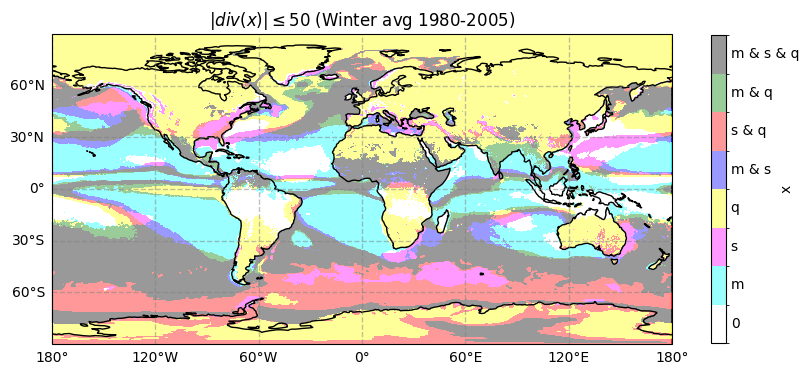

In [63]:
# Averaged over all time, then R1 calculated
fig, ax = plt.subplots(1, figsize=(10,5), subplot_kw = {'projection':ccrs.PlateCarree()})

cmap = colors.ListedColormap(['white','cyan','magenta','yellow','blue','red','green','black'])
labels = ['0','m','s','q','m & s', 's & q', 'm & q', 'm & s & q\n'] 

bounds = [0,1,2,3,4,5,6,7,10000]

im1 = ax.pcolormesh(df.longitude, df.latitude, 
                    x.mean_RCE_1, 
                    transform=ccrs.PlateCarree(), 
                    norm = colors.BoundaryNorm(boundaries=bounds, ncolors=8),
                    cmap=cmap, 
                    alpha=0.4
                   )

# Add coast- and gridlines
ax.coastlines(color='black')

gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

cbar = plt.colorbar(im1,ax=ax, shrink=0.8)
cbar.set_label('x', fontsize=10, labelpad=33)

cbar.ax.get_yaxis().set_ticks([])
for j, lab in enumerate(labels):
    cbar.ax.text(1.3, j + 0.4, lab, ha='left')
    
ax.set_title(r'$|div(x)| \leq 50 $ (Winter avg 1980-2005)')

plt.show()

In [ ]:
# Averaged over all time, then R1 calculated
fig, ax = plt.subplots(1, figsize=(20,30), subplot_kw = {'projection':ccrs.PlateCarree()})

im1 = ax.pcolormesh(df.longitude, df.latitude,
                    np.abs((df.divMSE).isel(date=7)) <= 50, 
                    transform=ccrs.PlateCarree(), vmin=0, vmax=1, cmap=cm.Blues,alpha=0.4)

im2 = ax.pcolormesh(df.longitude, df.latitude,
                    np.abs((df.divDSE).isel(date=7)) <= 50, 
                    transform=ccrs.PlateCarree(), vmin=0, vmax=1, cmap=cm.Greens,alpha=0.4)

im3 = ax.pcolormesh(df.longitude, df.latitude,
                    np.abs((df.divq).isel(date=7)) <= 50, 
                    transform=ccrs.PlateCarree(), vmin=0, vmax=1, cmap=cm.Reds,alpha=0.4)

# im4 = ax.contourf(df.longitude, 
#                     df.latitude,
#                     MSE_winter, 
#                     transform=ccrs.PlateCarree(), levels = [-50,50], hatches = [5*'/',''],colors='none')

# Add coast- and gridlines
ax.coastlines(color='black')

gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# ax.clabel(im2, im2.levels)

# Add title and legend
#ax.set_title(f'R1 = 1+(LH+SH)/Q average for 1980. Grid sizes are 0.25 deg lat and long', fontsize=24)

# cbar = plt.colorbar(im1,ax=ax,fraction=0.046, pad=0.04)
# cbar.set_label('\n Frac time in total RCE',fontsize=20)
# plt.savefig('./Plots/R1_1980_world.png')

In [ ]:
fig, ax = plt.subplots(1, figsize=(20,10), subplot_kw = {'projection':ccrs.PlateCarree()})

im1 = ax.pcolormesh(df.longitude, df.latitude,
                   frac_RCE3_summer, 
                    transform=ccrs.PlateCarree(), vmin=0, vmax=1, cmap=cm.Blues)
ax.coastlines(color='black')

gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

cbar = plt.colorbar(im1,ax=ax,fraction=0.046, pad=0.04)
cbar.set_label('\n Frac time in trip RCE',fontsize=20)


In [ ]:
fig, ax = plt.subplots(1, figsize=(20,10), subplot_kw = {'projection':ccrs.PlateCarree()})

im1 = ax.pcolormesh(df.longitude, df.latitude,
                   df.Q.mean('date')/(3600*24), 
                    transform=ccrs.PlateCarree(),  cmap=cm.Blues)
ax.coastlines(color='black')

gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

cbar = plt.colorbar(im1,ax=ax,fraction=0.046, pad=0.04)
cbar.set_label('\n Frac time in trip RCE',fontsize=20)
